### In this notebook we perform individual training.
In individual learning each base station has access only to it's private dataset.

In [15]:
import sys
import os

from pathlib import Path
# 解释：将当前目录的父目录加入到sys.path中，这样就可以在当前目录下导入父目录的模块
parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [16]:
import random

import numpy as np
import torch

from argparse import Namespace

In [17]:
# 解释
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers,read_data_yl


In [18]:
from ml.utils.train_utils import train, test

In [19]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [20]:
args = Namespace(
    # 数据路径
    data_path='/home/yanglin/Federated-Time-Series-Forecasting/dataset/yl/train_data.csv',  # 训练集路径
    data_path_test='/home/yanglin/Federated-Time-Series-Forecasting/dataset/yl/test_data.csv',  # 测试集路径
    test_size=0.2,  # 验证集大小
    
    # 预测目标
    targets=['needs_charging'],  # 需要预测的列
    
    # 时间序列参数
    num_lags=10,  # 输入特征的时间滞后数

    # 数据处理参数
    identifier='vehicle_id',  # 标识车辆的列名
    nan_constant=0,  # 替换NaN值的常数
    x_scaler='minmax',  # 特征标准化方法
    y_scaler='minmax',  # 目标标准化方法
    outlier_detection=None,  # 异常值处理设置为None

    # 模型训练参数
    criterion='mse',  # 损失函数
    epochs=150,  # 最大训练轮数
    lr=0.001,  # 学习率
    optimizer='adam',  # 优化器
    batch_size=128,  # 批量大小
    early_stopping=True,  # 是否使用早停机制
    patience=50,  # 早停耐心值
    max_grad_norm=0.0,  # 梯度裁剪
    reg1=0.0,  # L1正则化
    reg2=0.0,  # L2正则化
    
    # 其他设置
    plot_history=True,  # 是否绘制训练损失图
    cuda=True,  # 是否使用GPU
    seed=0,  # 随机种子
    assign_stats=None,  # 是否使用统计数据作为外生数据
    use_time_features=True  # 是否使用时间特征
)

> You can define the base station to perform train on the filter_bs parameter and use it in block 12 or you can define the base station to block 12 explicitly 

In [21]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='/home/yanglin/Federated-Time-Series-Forecasting/dataset/yl/train_data.csv', data_path_test='/home/yanglin/Federated-Time-Series-Forecasting/dataset/yl/test_data.csv', early_stopping=True, epochs=150, identifier='vehicle_id', lr=0.001, max_grad_norm=0.0, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=None, patience=50, plot_history=True, reg1=0.0, reg2=0.0, seed=0, targets=['needs_charging'], test_size=0.2, use_time_features=True, x_scaler='minmax', y_scaler='minmax')



In [22]:
import torch.version


device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print("torch_version",torch.__version__)
print("args.cuda",args.cuda)
print("torch.cuda.is_available()",torch.cuda.is_available())
print(f"Using {device}")

torch_version 2.3.0
args.cuda True
torch.cuda.is_available() False
Using cpu


In [23]:
# Outlier detection specification 异常值检测:暂时不需要异常值检测因为我们已经处理过
# if args.outlier_detection is not None:
#     outlier_columns = ['rb_down', 'rb_up', 'down', 'up'] #需要进行异常值检测的列名
#     outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)} #每个键是一个区域的名称，每个值是一个元组，用于指定该区域的异常值检测参数。"ElBorn": (10, 90)：表示对于ElBorn区域，异常值检测的阈值是10和90。
#     args.outlier_columns = outlier_columns 
#     args.outlier_kwargs = outlier_kwargs

In [24]:
def seed_all():
    # ensure reproducibility 确保结果的可重复性
    random.seed(args.seed) #设置Python标准库中的随机数生成器的种子为args.seed。这会影响使用random模块生成的所有随机数。
    np.random.seed(args.seed) #设置NumPy库的随机数生成器的种子为args.seed。这会影响使用numpy.random模块生成的所有随机数。
    torch.manual_seed(args.seed) #设置PyTorch库的随机数生成器的种子为args.seed。这会影响CPU上的所有PyTorch操作生成的随机数。
    torch.cuda.manual_seed_all(args.seed) #设置所有CUDA设备（即GPU）的随机数生成器的种子为args.seed。这会影响在GPU上执行的所有PyTorch操作生成的随机数。
    torch.backends.cudnn.deterministic = True #设置CuDNN后端为确定性模式，这意味着CuDNN将使用确定性的算法，从而确保相同的输入始终产生相同的输出。
    torch.backends.cudnn.benchmark = False #禁用CuDNN的benchmark模式。启用benchmark模式可能会导致不同的计算选择不同的算法，从而产生不同的结果，因此禁用它可以确保结果的一致性。

In [25]:
seed_all()

### The preprocessing pipeline performed here for the base station specified in filter_bs argument
Preprocessing inlcudes:
1. NaNs Handling NANs处理
2. Outliers Handling 异常值处理
3. Scaling Data 数据缩放
4. Generating time lags 生成时间滞后
5. Generating and importing exogenous data as features (time, statistics) (if applied) 生成和导入外生数据

In [26]:



def make_preprocessing(filter_data=None): 
    #本函数接受一个可选参数‘filter_bs’,用于指定要过滤的基站。如果没有提供该参数，则处理所有基站的数据。
    """Preprocess a given .csv"""
    # read data 使用read_data函数读取指定路径（args.data_path）的CSV数据，并根据filter_bs过滤数据。
    df = read_data_yl(args.data_path, filter_data=filter_data)
    # # handle nans 使用handle_nans函数处理数据中的缺失值。缺失值将被替换为args.nan_constant指定的常数。
    # df = handle_nans(train_data=df, constant=args.nan_constant,
    #                  identifier=args.identifier)
    # # split to train/validation 将数据集划分为训练集和验证集。具体的划分比例由预先定义的参数决定。
    # train_data, val_data = to_train_val(df)
    
    # # handle outliers (if specified) 如果启用了异常值检测（args.outlier_detection不为None），则使用handle_outliers函数处理训练数据中的异常值。
    # if args.outlier_detection is not None:
    #     train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
    #                                  identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # # get X and y 将训练集和验证集中的特征（X）和目标变量（y）分离出来。
    # X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
    #                                       targets=args.targets)
    # # 对特征数据和目标变量分别进行缩放（标准化或归一化），以确保它们在相似的尺度上。缩放方法由args.x_scaler和args.y_scaler指定。
    # # scale X
    # X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
    #                                          scaler=args.x_scaler, identifier=args.identifier)
    # # scale y
    # y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
    #                                          scaler=args.y_scaler, identifier=args.identifier)
    
    # # generate time lags 生成时间滞后特征，即在时间序列数据中，使用过去若干时间步的数据作为当前时间步的输入特征。
    # X_train = generate_time_lags(X_train, args.num_lags)
    # X_val = generate_time_lags(X_val, args.num_lags)
    # y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    # y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # #生成并导入时间特征（如时间戳、日期等）和统计特征（如均值、方差等），作为外生数据特征。
    # # get datetime features as exogenous data
    # date_time_df_train = time_to_feature(
    #     X_train, args.use_time_features, identifier=args.identifier
    # )
    # date_time_df_val = time_to_feature(
    #     X_val, args.use_time_features, identifier=args.identifier
    # )
    
    # # get statistics as exogenous data
    # stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
    #                                    targets=args.targets, identifier=args.identifier)
    # stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
    #                                    targets=args.targets, identifier=args.identifier)
    
    # #合并生成的外生特征（时间特征和统计特征），并去除重复的列。如果没有外生特征，则设为None。
    # #exogenous_data_train 和 exogenous_data_val如果不为 None，这些是训练集和验证集的外生特征数据。
    # # concat the exogenous features (if any) to a single dataframe
    # if date_time_df_train is not None or stats_df_train is not None:
    #     exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
    #     # remove duplicate columns (if any)
    #     exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
    #     assert len(exogenous_data_train) == len(X_train) == len(y_train)
    # else:
    #     exogenous_data_train = None
    # if date_time_df_val is not None or stats_df_val is not None:
    #     exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
    #     exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
    #     assert len(exogenous_data_val) == len(X_val) == len(y_val)
    # else:
    #     exogenous_data_val = None
        
    # return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [14]:
# here exogenous_data_train and val are None.
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing(
    filter_data="A032"
)

INFO logger 2024-05-29 01:51:13,480 | data_utils.py:53 | Reading data for vehicle ID A032...


ValueError: could not convert string to float: '   Navigation'

In [627]:
X_train.head()
#time：时间戳，表示数据记录的具体时间
#down：下行流量，单位可能是字节
#up：上行流量，单位可能是字节
#rnti_count：RNTI（Radio Network Temporary Identifier）计数，表示在指定时间内活跃的RNTI数量。
#mcs_down：下行调制和编码方案（MCS，Modulation and Coding Scheme）的平均值，表示下行链路的调制和编码效率。
#mcs_down_var：下行MCS的方差，表示下行链路调制和编码效率的变化程度
#mcs_up：上行调制和编码方案（MCS，Modulation and Coding Scheme）的平均值，表示上行链路的调制和编码效率。
#mcs_up_var：上行MCS的方差，表示上行链路调制和编码效率的变化程度
#rb_down：下行资源块（RB，Resource Block）的平均值，表示在指定时间内下行链路使用的资源块的平均数量。
#rb_down_var：下行资源块的方差，表示下行链路资源块使用数量的变化程度
#rb_up：上行资源块（RB，Resource Block）的平均值，表示在指定时间内上行链路使用的资源块的平均数量
#rb_up_var：上行资源块的方差，表示上行链路资源块使用数量的变化程度

,rb_up_var_lag-10,rb_up_lag-10,rb_down_var_lag-10,rb_down_lag-10,mcs_up_var_lag-10,mcs_up_lag-10,mcs_down_var_lag-10,mcs_down_lag-10,rnti_count_lag-10,up_lag-10,...,rb_down_var_lag-1,rb_down_lag-1,mcs_up_var_lag-1,mcs_up_lag-1,mcs_down_var_lag-1,mcs_down_lag-1,rnti_count_lag-1,up_lag-1,down_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2019-01-12 17:32:00,1.083682e-08,0.036054,1.961025e-08,0.109670,0.493544,0.431702,0.459601,0.160269,0.210509,0.017705,...,1.974816e-08,0.114193,0.572030,0.400005,0.460896,0.164719,0.212757,0.018888,0.131219,LesCorts
2019-01-12 17:34:00,1.061491e-08,0.030426,1.644211e-08,0.098938,0.527483,0.476772,0.392094,0.131085,0.200300,0.018282,...,1.791601e-08,0.105544,0.576015,0.445876,0.427184,0.145817,0.192432,0.014424,0.113276,LesCorts
2019-01-12 17:36:00,9.109702e-09,0.038901,1.761309e-08,0.106045,0.501063,0.471773,0.453949,0.152725,0.221468,0.019501,...,1.766410e-08,0.101075,0.640010,0.448971,0.387407,0.130386,0.173137,0.011194,0.101414,LesCorts
2019-01-12 17:38:00,5.813802e-09,0.026050,1.668480e-08,0.098968,0.499865,0.450949,0.382516,0.129036,0.183768,0.012594,...,1.963081e-08,0.114777,0.534812,0.414812,0.476978,0.171880,0.205545,0.023585,0.141225,LesCorts
2019-01-12 17:40:00,7.246522e-09,0.028981,1.721707e-08,0.102669,0.535319,0.429488,0.412994,0.139577,0.191964,0.013056,...,1.895823e-08,0.107131,0.547422,0.456544,0.448805,0.157300,0.181567,0.022127,0.125069,LesCorts


In [628]:
#解释
X_val.head()


,rb_up_var_lag-10,rb_up_lag-10,rb_down_var_lag-10,rb_down_lag-10,mcs_up_var_lag-10,mcs_up_lag-10,mcs_down_var_lag-10,mcs_down_lag-10,rnti_count_lag-10,up_lag-10,...,rb_down_var_lag-1,rb_down_lag-1,mcs_up_var_lag-1,mcs_up_lag-1,mcs_down_var_lag-1,mcs_down_lag-1,rnti_count_lag-1,up_lag-1,down_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2019-01-20 09:20:00,4.728611e-09,0.000378,4.323541e-08,0.058302,0.401278,0.501344,0.919491,0.935376,0.123355,0.000206,...,4.402667e-08,0.072691,0.111839,0.444416,0.885758,0.931423,0.154451,0.000336,0.180818,LesCorts
2019-01-20 09:22:00,9.995833e-10,0.000330,4.508320e-08,0.056214,0.159144,0.393817,0.841731,0.960886,0.118906,0.000160,...,4.474956e-08,0.109179,0.275191,0.471308,0.877144,0.933492,0.222077,0.000623,0.264679,LesCorts
2019-01-20 09:24:00,1.217479e-08,0.000859,4.771216e-08,0.097153,0.301473,0.467948,0.869250,0.931095,0.202079,0.000558,...,4.620672e-08,0.140548,0.407761,0.487723,0.900534,0.947047,0.287079,0.000887,0.343279,LesCorts
2019-01-20 09:26:00,9.579305e-09,0.000850,4.462743e-08,0.100799,0.333194,0.519904,0.868349,0.948227,0.202641,0.000568,...,4.512395e-08,0.098633,0.307474,0.474030,0.852834,0.955406,0.203906,0.000384,0.241753,LesCorts
2019-01-20 09:28:00,2.505653e-08,0.001541,4.706725e-08,0.135352,0.406647,0.504277,0.900401,0.945294,0.270641,0.001207,...,4.390479e-08,0.076930,0.214200,0.541009,0.900236,0.940772,0.160727,0.000374,0.191878,LesCorts


In [629]:
y_train.head()

,rnti_count,rb_down,rb_up,down,up,District
time,,,,,,
2019-01-12 17:32:00,0.192432,0.105544,0.033785,0.113276,0.014424,LesCorts
2019-01-12 17:34:00,0.173137,0.101075,0.025216,0.101414,0.011194,LesCorts
2019-01-12 17:36:00,0.205545,0.114777,0.060088,0.141225,0.023585,LesCorts
2019-01-12 17:38:00,0.181567,0.107131,0.042592,0.125069,0.022127,LesCorts
2019-01-12 17:40:00,0.175900,0.101726,0.023463,0.107920,0.011213,LesCorts


In [630]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

### Postprocessing Stage

In this stage we transform data in a way that can be fed into ML algorithms.

In [631]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    #X_train, X_val: 训练集和验证集的特征数据。
    #y_train, y_val: 训练集和验证集的目标数据。
    #exogenous_data_train, exogenous_data_val: 训练集和验证集的外生数据。
    #x_scaler, y_scaler: 特征数据和目标数据的缩放器。
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area 
    #检查训练数据集中是否有多个不同的区域（由 args.identifier 标识）。如果有多个区域，则调用 get_data_by_area 函数将数据按区域分割。
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area. 获取每个区域的外生数据 如果存在外生数据，则将其按区域分割。
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np 将区域划分的数据转换为 NumPy 数组，并移除标识符列（如区域名称）。
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets 对整体数据集，移除标识符列，并确保训练集和验证集的特征列数相同。
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    #计算特征数量，这里每个特征都有多个滞后期，所以除以滞后期的数量
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation 将特征数据转换为时间序列表示，即构建时间滞后的特征集
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy 将目标数据转换为 NumPy 数组
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    # centralized (all) learning specific 在集中学习的情况下，将所有区域的外生数据合并成一个数据集
    if not args.filter_bs and exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [632]:
X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [633]:
X_train[:2]

array([[[[1.08368177e-08],
         [3.60536501e-02],
         [1.96102530e-08],
         [1.09670356e-01],
         [4.93544310e-01],
         [4.31701750e-01],
         [4.59600508e-01],
         [1.60269260e-01],
         [2.10509062e-01],
         [1.77047513e-02],
         [1.29703119e-01]],

        [[1.06149072e-08],
         [3.04260999e-02],
         [1.64421117e-08],
         [9.89375487e-02],
         [5.27482629e-01],
         [4.76772249e-01],
         [3.92093986e-01],
         [1.31084532e-01],
         [2.00299725e-01],
         [1.82819255e-02],
         [9.46676582e-02]],

        [[9.10970233e-09],
         [3.89005616e-02],
         [1.76130861e-08],
         [1.06044851e-01],
         [5.01062572e-01],
         [4.71772611e-01],
         [4.53948647e-01],
         [1.52724519e-01],
         [2.21467718e-01],
         [1.95014086e-02],
         [1.11105040e-01]],

        [[5.81380233e-09],
         [2.60500330e-02],
         [1.66847958e-08],
         [9.89684388e-

In [634]:
y_train[:2]

array([[0.19243199, 0.1055439 , 0.03378513, 0.11327641, 0.01442373],
       [0.17313728, 0.10107498, 0.02521631, 0.10141373, 0.01119418]],
      dtype=float32)

In [635]:
len(X_train), len(X_val)

(5504, 1368)

### Define the input dimensions for the model architecture

In [636]:
def get_input_dims(X_train, exogenous_data_train): 
    #计算模型输入的维度，X_train: 训练集的主输入数据（通常是一个多维数组）；exogenous_data_train: 训练集的外生数据（可以是 None 或包含外生特征的字典）。
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2] #如果模型是多层感知机（MLP），则将输入的所有特征展平成一个一维向量，因此输入维度是 X_train 的第二维度和第三维度的乘积（即 X_train.shape[1] * X_train.shape[2]）
    else:
        input_dim = X_train.shape[2] #对于其他模型（如卷积神经网络或循环神经网络），输入维度保持为 X_train 的第三维度（即 X_train.shape[2]）
    #计算外生数据的维度
    if exogenous_data_train is not None: #如果 exogenous_data_train 不为 None
        if len(exogenous_data_train) == 1: #如果外生数据中只有一个区域
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1] #从字典中获取该区域的维度。
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1] #如果外生数据中有多个区域，则使用键为 "all" 的区域的维度
    else:
        exogenous_dim = 0 #如果 exogenous_data_train 为 None，则外生数据的维度为 0
    
    return input_dim, exogenous_dim #input_dim: 主输入数据的维度；exogenous_dim: 外生数据的维度

### Initialize the model for training

In [637]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [638]:
# define the model
args.model_name = "mlp"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

110 0


In [639]:
model

MLP(
  (MLP_layers): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=5, bias=True)
  )
)

### The fit function used to train the model specified above

In [640]:
def fit(model, X_train, y_train, X_val, y_val, #model: 需要训练的模型；X_train, y_train: 训练数据和标签；X_val, y_val: 验证数据和标签
        exogenous_data_train=None, exogenous_data_val=None, #exogenous_data_train, exogenous_data_val: 训练和验证数据的外生特征
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X ；idxs: 目标变量在输入数据中的索引
        log_per=1): #log_per: 记录训练日志的频率
    
    # get exogenous data (if any)
    if exogenous_data_train is not None and len(exogenous_data_train) > 1:
        exogenous_data_train = exogenous_data_train["all"]
        exogenous_data_val = exogenous_data_val["all"]
    elif exogenous_data_train is not None and len(exogenous_data_train) == 1:
        cid = next(iter(exogenous_data_train.keys()))
        exogenous_data_train = exogenous_data_train[cid]
        exogenous_data_val = exogenous_data_val[cid]
    else:
        exogenous_data_train = None
        exogenous_data_val = None
    num_features = len(X_train[0][0]) #计算特征数量，X_train 是一个 3D 数组，形状为 (num_samples, num_lags, num_features)
    
    # to torch loader
    train_loader = to_torch_dataset(X_train, y_train,
                                    num_lags=args.num_lags,
                                    num_features=num_features,
                                    exogenous_data=exogenous_data_train,
                                    indices=idxs,
                                    batch_size=args.batch_size, 
                                    shuffle=False)
    val_loader = to_torch_dataset(X_val, y_val, 
                                  num_lags=args.num_lags,
                                  num_features=num_features,
                                  exogenous_data=exogenous_data_val,
                                  indices=idxs,
                                  batch_size=args.batch_size,
                                  shuffle=False)
    
    # train the model
    model = train(model, 
                  train_loader, val_loader,
                  epochs=args.epochs,
                  optimizer=args.optimizer, lr=args.lr,
                  criterion=args.criterion,
                  early_stopping=args.early_stopping,
                  patience=args.patience,
                  plot_history=args.plot_history, 
                  device=device, log_per=log_per)
    
    
    return model

INFO logger 2024-05-23 16:58:32,012 | train_utils.py:103 | Epoch 1 [Train]: loss 0.011130027884043324, mse: 0.006565061863511801, rmse: 0.08102506935209498, mae 0.06446090340614319, r2: -0.9310417009027339, nrmse: 3.5501599677534847
INFO logger 2024-05-23 16:58:32,012 | train_utils.py:105 | Epoch 1 [Test]: loss 4.700729412391608e-05, mse: 0.00573458056896925, rmse: 0.07572701346923204, mae 0.06321828067302704, r2: -3194.345268166287, nrmse: 38.788018304435994
INFO logger 2024-05-23 16:58:32,012 | helpers.py:148 | Validation loss decreased (inf --> 0.000047). Caching model ...
INFO logger 2024-05-23 16:58:32,115 | train_utils.py:103 | Epoch 2 [Train]: loss 0.003760452933081894, mse: 0.003090707352384925, rmse: 0.0555941305569655, mae 0.03789808601140976, r2: -0.03257373853291066, nrmse: 2.7394794260928608
INFO logger 2024-05-23 16:58:32,115 | train_utils.py:105 | Epoch 2 [Test]: loss 2.0606662585857538e-05, mse: 0.002571853343397379, rmse: 0.05071344341885472, mae 0.03754692152142525, r

INFO logger 2024-05-23 16:58:32,741 | train_utils.py:103 | Epoch 7 [Train]: loss 0.0022481655487248393, mse: 0.0023429328575730324, rmse: 0.04840385168117339, mae 0.0317036397755146, r2: 0.5484767028965292, nrmse: 1.5117997821582883
INFO logger 2024-05-23 16:58:32,741 | train_utils.py:105 | Epoch 7 [Test]: loss 1.4560868315485835e-05, mse: 0.0018366407603025436, rmse: 0.042856046951422665, mae 0.027722066268324852, r2: -105.28509861635764, nrmse: 7.823383412779401
INFO logger 2024-05-23 16:58:32,741 | helpers.py:148 | Validation loss decreased (0.000015 --> 0.000015). Caching model ...
INFO logger 2024-05-23 16:58:32,846 | train_utils.py:103 | Epoch 8 [Train]: loss 0.0022377225839929535, mse: 0.0019373869290575385, rmse: 0.044015757735810235, mae 0.027366673573851585, r2: 0.6787241211551985, nrmse: 1.187368269664122
INFO logger 2024-05-23 16:58:32,846 | train_utils.py:105 | Epoch 8 [Test]: loss 1.4576601318617443e-05, mse: 0.001834755763411522, rmse: 0.04283404911296061, mae 0.02839132

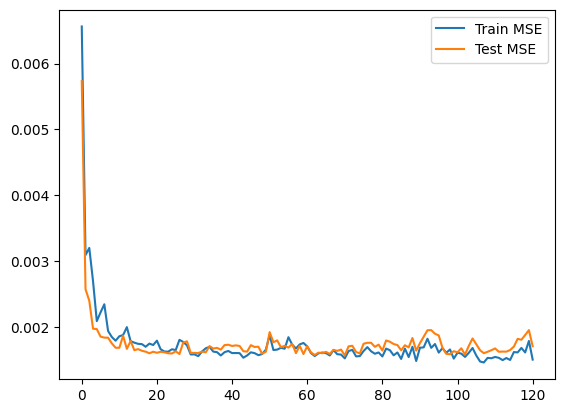

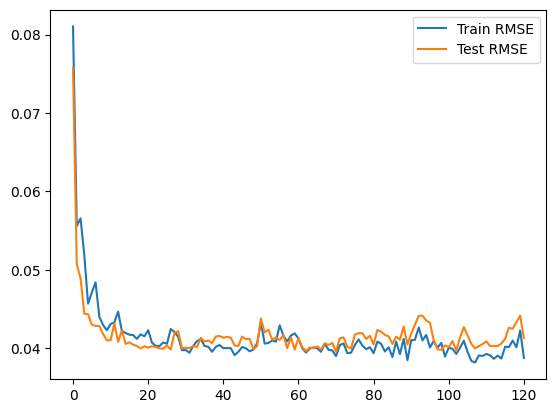

INFO logger 2024-05-23 16:58:47,278 | train_utils.py:146 | Best Loss: 1.2392443814110665e-05, Best epoch: 121


In [641]:
trained_model = fit(model, X_train, y_train, X_val, y_val)